In [1]:
import os
os.environ['THEANO_FLAGS']="device=cpu"

from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

In [2]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

#Load models and data

In [3]:
model_folders = [model_folder \
               for model_folder in os.listdir(dir_model) \
               if os.path.isdir(os.path.join(dir_model,model_folder))]
model_folders = ['Z2_300','Z2_230','Z2_100']

In [4]:
models = [serial.load(os.path.join(dir_model,model_folder,'finetune.pkl')) for model_folder in model_folders]

In [5]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

#Define graph

In [6]:
Xs = [model.get_input_space().make_theano_batch() for model in models]
Ys = [model.fprop(X) for (model,X) in zip(models,Xs)]

#Compute output

In [7]:
Xhats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Ys)]

Using gpu device 0: GeForce GT 650M


##visualize outputs

original


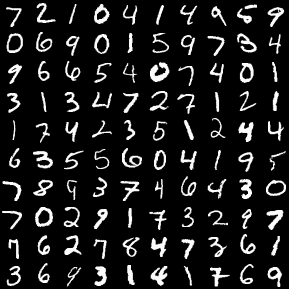

In [8]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('temp.png')
print 'original'
I.display(I.Image('temp.png'))

Z2_300


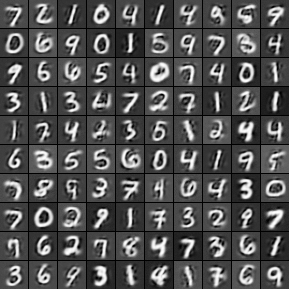

Z2_230


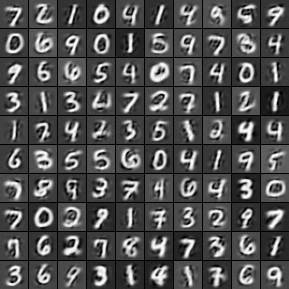

Z2_100


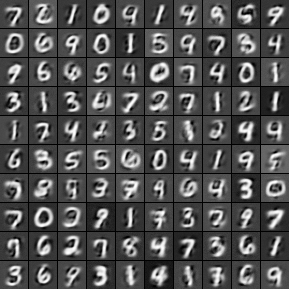

In [9]:
for (xhat,model_folder) in zip(Xhats,model_folders):
    reconstructed = Image.fromarray(tile_raster_images(X=xhat,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
    reconstructed.save(model_folder+'.png')
    print model_folder
    I.display(I.Image(model_folder+'.png'))